In [1]:
# Data processing script
# 
# assign working directory path
wd.path <- "~/in"
setwd(wd.path)
set.seed(1234)
library(dplyr)
# library(foreach)
# library(caret)
# library(reshape2)
library(rms)
library(WeightedROC)

#Sample mode function from Source: https://stackoverflow.com/questions/2547402/is-there-a-built-in-function-for-finding-the-mode
Mode <- function(x, na.rm = FALSE) {
  if (na.rm) {
    x = x[!is.na(x)]
  }
  
  ux <- unique(x)
  return(ux[which.max(tabulate(match(x, ux)))])
}

imputationFunction <- function(imputeToData, imputeFromData, FUN, missingCols, suffix){
  # imputeToData -  Imputation to be done on this data
  # imputeFromData - Imputations calculation from this data
  # FUN - imputation function
  # missingCols - missing value column names
  # suffix - suffix to add after column name
  
  imputeToData <- imputeToData[, names(imputeToData) %in% missingCols]
  imputeFromData <- imputeFromData[, names(imputeFromData) %in% missingCols]
  imputeVec <- apply(imputeFromData, 2, function(x) FUN(x, na.rm = T))
  
  for (i in 1:length(missingCols)) {
    imputeToxData[is.na(imputeToData[, names(imputeToData) %in% missingCols[i]])
                 , names(imputeToData) %in% missingCols[i]] <- imputeVec[names(imputeVec) %in% missingCols[i]]
  }
  
  names(imputeToData) <- paste0(names(imputeToData), suffix)
  return(imputeToData)
}


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union

Loading required package: Hmisc
Loading required package: lattice
Loading required package: survival
Loading required package: Formula
Loading required package: ggplot2

Attaching package: ‘Hmisc’

The following objects are masked from ‘package:dplyr’:

    combine, src, summarize

The following objects are masked from ‘package:base’:

    format.pval, round.POSIXt, trunc.POSIXt, units

Loading required package: SparseM

Attaching package: ‘SparseM’

The following object is masked from ‘package:base’:

    backsolve



In [ ]:
test <- read.csv('application_test.csv') # applications test data
train <- read.csv('application_train.csv') # applications train data

# storing column names for later
saveNames <- names(train)

# columns with missing values
missingCols <-  names(train)[apply(train, 2, function(x) sum(is.na(x))) > 0]
                                   
#train imputation
medianDatatr <- imputationFunction(imputeToData = train, imputeFromData = train, FUN = median
                                   , missingCols = missingCols, suffix = '.trmedian')

#test imputation
medianDatatst.tst <- imputationFunction(imputeToData = test, imputeFromData = test, FUN = median
                                    , missingCols = missingCols, suffix = '.tstmedian')

## Initial Transformation to get to the Imputed Dataset

In [ ]:
weights <- read.csv('Weights_and_fold.csv')
print("Weights loaded")
train <- cbind(train, medianDatatr) %>% left_join(weights, by = "SK_ID_CURR")
write.csv(train,'application_train_imp.csv')
test <- cbind(test, medianDatatst.tst)
write.csv(test,'application_test_imp.csv')
rm(medianDatatr, medianDatatst.tst, weights)

In [ ]:
weights <- read.csv('V2_weight_R_code(Alex)/Train_Weights_V2.csv')
train <- read.csv('application_train_imp.csv') # applications train data
train <- train %>% select(-Weights, -X) %>% left_join(weights, by = "SK_ID_CURR") %>% select(-X)
write.csv(train,'application_train_imp.csv')

## Start Here for Subsequent Runs, read in the processed dataset

In [2]:
test <- read.csv('application_test_imp.csv') # applications test data
train <- read.csv('application_train_imp.csv') # applications train data

In [ ]:
# Mechanically create a formula for rms modeling
M = train

col_set = M %>% names()
col_set = col_set[!col_set %in% "TARGET"]

string_formula = "TARGET~"
for(i in col_set){
  if(class(M[[i]]) == "numeric"){
    tmp_component = paste0("+rcs(",i,",3)")
  }
  if(class(M[[i]]) != "numeric"){
    tmp_component = paste0("+",i)
  }
  string_formula = paste0(string_formula, tmp_component)  
}
requested_formula = as.formula(string_formula)
requested_formula

### Base Model + AMT_CREDIT (Model FF_rms_2)

In [7]:
#Perform 5 fold cross validation
model = list()
mod_anova = list()
test_roc = list()

for(i in 1:5){
    testData <- train[train$fold==i,]
    trainData <- train[train$fold!=i,]
    string_formula <- TARGET ~ NAME_CONTRACT_TYPE + CODE_GENDER + FLAG_OWN_CAR + FLAG_OWN_REALTY + rcs(EXT_SOURCE_1.trmedian, 4) + 
            rcs(EXT_SOURCE_2.trmedian, 4) + rcs(EXT_SOURCE_3.trmedian,4) + rcs(AMT_CREDIT, 3)
    requested_formula = as.formula(string_formula)
    a_model = lrm(data=trainData, formula = requested_formula, weight=Weights, tol=1E-10, x=TRUE,y=TRUE)
        
    # diagnostic plots
    ## Variable Importance
    mod_anova[[i]] <- anova(a_model)
    
    ## Validation Statistics
    print(validate(a_model, B=10))
    model[[i]] <- a_model

    ## Calibration Curve
    # plot(calibrate(a_model, B=10))

    # use a fitted model to score a dataset, convert score to probability
    test_scored <- cbind(testData, predict(a_model, testData, se.fit=TRUE))
    test_scored$pred = exp(test_scored$linear.predictors)/(1+exp(test_scored$linear.predictors))

    # Weighted AUROC
    tp.fp <- WeightedROC(test_scored$pred,test_scored$TARGET,test_scored$Weights)
    test_roc[[i]] <- WeightedAUC(tp.fp)
    print(test_roc[[i]])

    # Unweighted AUROC
    tp.fp <- WeightedROC(test_scored$pred,test_scored$TARGET)
    print(WeightedAUC(tp.fp))
    
}

Warning message in lrm(data = trainData, formula = requested_formula, weight = Weights, :
“currently weights are ignored in model validation and bootstrapping lrm fits”

          index.orig training    test optimism index.corrected  n
Dxy           0.4424   0.4598  0.4584   0.0014          0.4410 10
R2            0.1095   0.1197  0.1189   0.0009          0.1087 10
Intercept     0.0000   0.0000 -0.0107   0.0107         -0.0107 10
Slope         1.0000   1.0000  0.9953   0.0047          0.9953 10
Emax          0.0000   0.0000  0.0031   0.0031          0.0031 10
D             0.0031   0.0528  0.0524   0.0004          0.0027 10
U             0.0000   0.0000  0.0000   0.0000          0.0000 10
Q             0.0031   0.0528  0.0524   0.0004          0.0027 10
B             0.0699   0.0697  0.0697   0.0000          0.0699 10
g             1.0125   0.9770  0.9730   0.0040          1.0085 10
gp            0.0659   0.0674  0.0671   0.0003          0.0656 10
[1] 0.7387135
[1] 0.7208082


Warning message in lrm(data = trainData, formula = requested_formula, weight = Weights, :
“currently weights are ignored in model validation and bootstrapping lrm fits”

          index.orig training   test optimism index.corrected  n
Dxy           0.4426   0.4594 0.4588   0.0006          0.4420 10
R2            0.1132   0.1198 0.1196   0.0002          0.1130 10
Intercept     0.0000   0.0000 0.0049  -0.0049          0.0049 10
Slope         1.0000   1.0000 1.0001  -0.0001          1.0001 10
Emax          0.0000   0.0000 0.0012   0.0012          0.0012 10
D             0.0031   0.0528 0.0528   0.0000          0.0031 10
U             0.0000   0.0000 0.0000   0.0000          0.0000 10
Q             0.0031   0.0528 0.0528   0.0000          0.0031 10
B             0.0700   0.0695 0.0697  -0.0002          0.0702 10
g             1.0670   0.9694 0.9686   0.0007          1.0663 10
gp            0.0660   0.0672 0.0673  -0.0001          0.0662 10
[1] 0.7102572
[1] 0.7195507


Warning message in lrm(data = trainData, formula = requested_formula, weight = Weights, :
“currently weights are ignored in model validation and bootstrapping lrm fits”

          index.orig training    test optimism index.corrected  n
Dxy           0.4377   0.4587  0.4569   0.0018          0.4359 10
R2            0.1112   0.1197  0.1189   0.0008          0.1105 10
Intercept     0.0000   0.0000 -0.0066   0.0066         -0.0066 10
Slope         1.0000   1.0000  0.9959   0.0041          0.9959 10
Emax          0.0000   0.0000  0.0021   0.0021          0.0021 10
D             0.0031   0.0528  0.0525   0.0003          0.0028 10
U             0.0000   0.0000  0.0000   0.0000          0.0000 10
Q             0.0031   0.0528  0.0525   0.0003          0.0028 10
B             0.0701   0.0696  0.0698  -0.0002          0.0703 10
g             1.0646   0.9721  0.9682   0.0039          1.0607 10
gp            0.0669   0.0672  0.0671   0.0001          0.0668 10
[1] 0.7206843
[1] 0.7207265


Warning message in lrm(data = trainData, formula = requested_formula, weight = Weights, :
“currently weights are ignored in model validation and bootstrapping lrm fits”

          index.orig training    test optimism index.corrected  n
Dxy           0.4499   0.4623  0.4592   0.0030          0.4468 10
R2            0.1125   0.1212  0.1197   0.0015          0.1111 10
Intercept     0.0000   0.0000 -0.0103   0.0103         -0.0103 10
Slope         1.0000   1.0000  0.9940   0.0060          0.9940 10
Emax          0.0000   0.0000  0.0032   0.0032          0.0032 10
D             0.0031   0.0533  0.0527   0.0006          0.0024 10
U             0.0000   0.0000  0.0000   0.0000          0.0000 10
Q             0.0031   0.0533  0.0527   0.0006          0.0024 10
B             0.0696   0.0692  0.0694  -0.0001          0.0698 10
g             1.0474   0.9853  0.9782   0.0070          1.0404 10
gp            0.0648   0.0674  0.0671   0.0003          0.0644 10
[1] 0.703966
[1] 0.7206597


Warning message in lrm(data = trainData, formula = requested_formula, weight = Weights, :
“currently weights are ignored in model validation and bootstrapping lrm fits”

singular information matrix in lrm.fit (rank= 15 ).  Offending variable(s):
CODE_GENDER=XNA 
singular information matrix in lrm.fit (rank= 15 ).  Offending variable(s):
CODE_GENDER=XNA 
singular information matrix in lrm.fit (rank= 15 ).  Offending variable(s):
CODE_GENDER=XNA 
singular information matrix in lrm.fit (rank= 15 ).  Offending variable(s):
CODE_GENDER=XNA 
singular information matrix in lrm.fit (rank= 15 ).  Offending variable(s):
CODE_GENDER=XNA 

Divergence or singularity in 5 samples
          index.orig training    test optimism index.corrected n
Dxy           0.4417   0.4579  0.4562   0.0017          0.4401 5
R2            0.1135   0.1192  0.1181   0.0011          0.1124 5
Intercept     0.0000   0.0000 -0.0051   0.0051         -0.0051 5
Slope         1.0000   1.0000  0.9957   0.0043          0.9957 5
Emax          0.0000   0.0000  0.0019   0.0019          0.0019 5
D             0.0032   0.0524  0.0520   0.0004          0.0028 5
U             0.0000   0.0000  0.0000   

In [ ]:
#Perform 5 fold cross validation
model = list()
mod_anova = list()
test_roc = list()

for(i in 1:5){
    testData <- train[train$fold==i,]
    trainData <- train[train$fold!=i,]
    string_formula <- TARGET ~ NAME_CONTRACT_TYPE + CODE_GENDER + FLAG_OWN_CAR + FLAG_OWN_REALTY + rcs(EXT_SOURCE_1.trmedian, 4) + 
            rcs(EXT_SOURCE_2.trmedian, 4) + rcs(EXT_SOURCE_3.trmedian,4)
    requested_formula = as.formula(string_formula)
    a_model = lrm(data=trainData, formula = requested_formula, weight=Weights, tol=1E-10, x=TRUE,y=TRUE)
        
    # diagnostic plots
    ## Variable Importance
    mod_anova[[i]] <- anova(a_model)
    
    ## Validation Statistics
    print(validate(a_model, B=10))
    model[[i]] <- a_model

    ## Calibration Curve
    # plot(calibrate(a_model, B=10))

    # use a fitted model to score a dataset, convert score to probability
    test_scored <- cbind(testData, predict(a_model, testData, se.fit=TRUE))
    test_scored$pred = exp(test_scored$linear.predictors)/(1+exp(test_scored$linear.predictors))

    # Weighted AUROC
    tp.fp <- WeightedROC(test_scored$pred,test_scored$TARGET,test_scored$Weights)
    test_roc[[i]] <- WeightedAUC(tp.fp)
    print(test_roc[[i]])

    # Unweighted AUROC
    tp.fp <- WeightedROC(test_scored$pred,test_scored$TARGET)
    print(WeightedAUC(tp.fp))
    
}

In [ ]:
# Trying to understand why adding AMT_CREDIT, AMT_INCOME_TOTAL to the model would cause information matrix singularity
train_samp_col <- train %>% select(AMT_CREDIT, AMT_INCOME_TOTAL)
hist(train_samp_col)
# the value seems pretty ordinary

cor(trainData[,c("EXT_SOURCE_1.trmedian", "EXT_SOURCE_2.trmedian", "EXT_SOURCE_3.trmedian", "AMT_CREDIT", "AMT_INCOME_TOTAL")])

### Train FF_rms_2 on the full dataset and create submission

Warning message in lrm(data = train, formula = requested_formula, weight = Weights, :
“currently weights are ignored in model validation and bootstrapping lrm fits”

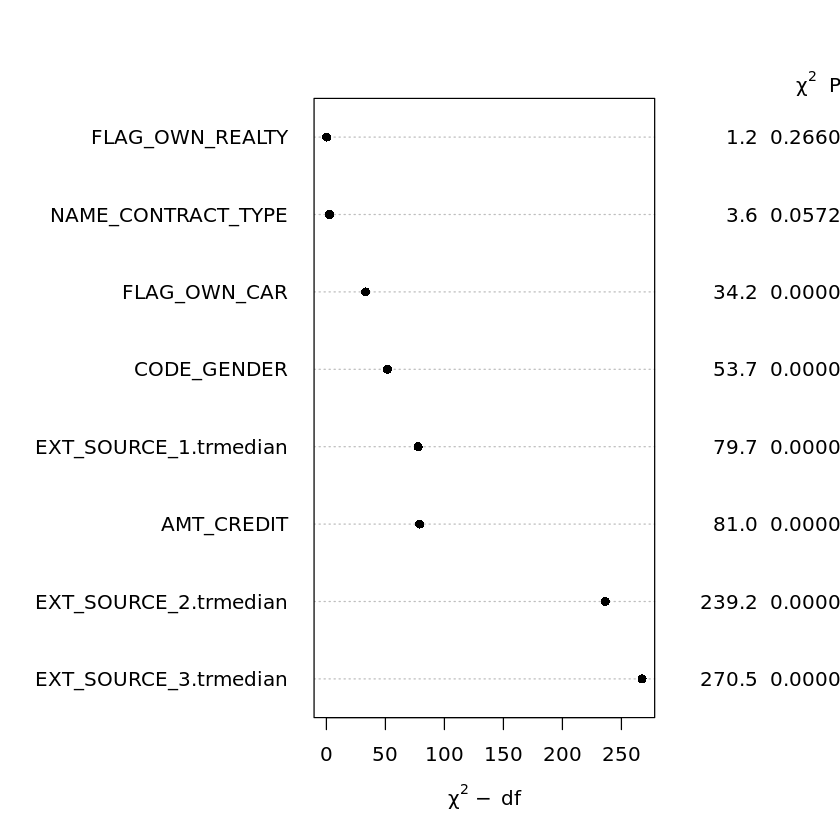

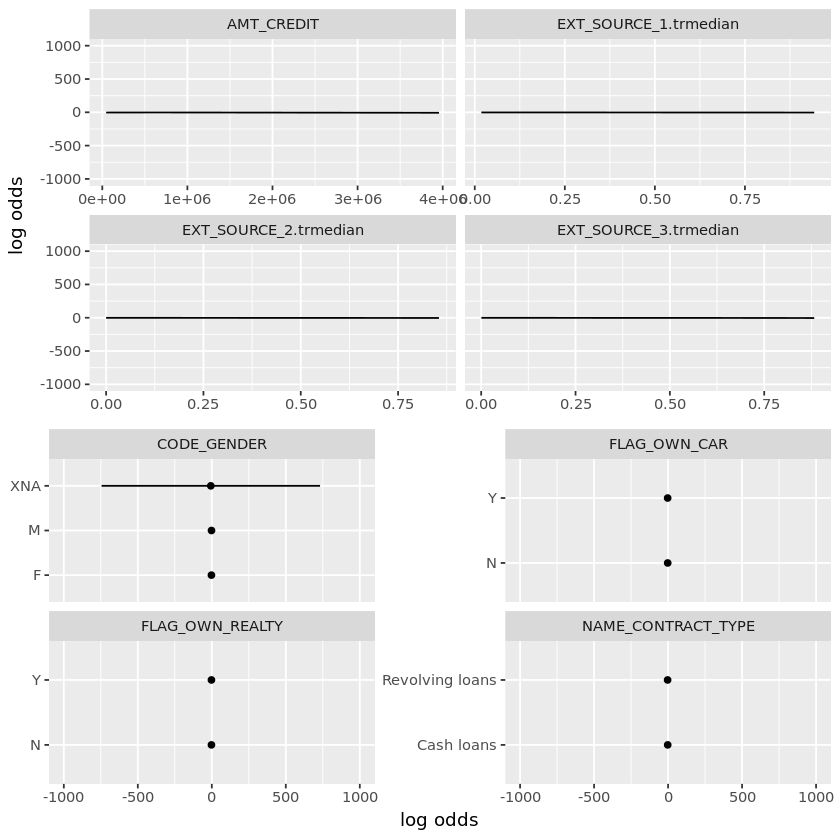

In [3]:
string_formula <- TARGET ~ NAME_CONTRACT_TYPE + CODE_GENDER + FLAG_OWN_CAR + FLAG_OWN_REALTY + rcs(EXT_SOURCE_1.trmedian, 4) + 
            rcs(EXT_SOURCE_2.trmedian, 4) + rcs(EXT_SOURCE_3.trmedian,4) + rcs(AMT_CREDIT, 3)
requested_formula = as.formula(string_formula)
a_model = lrm(data=train, formula = requested_formula, weight=Weights, tol=1E-10, x=TRUE,y=TRUE)

# Diagnostic Plots
## Variable Importance
plot(anova(a_model))
## Partial Effect Plot
dd <- datadist(train); options(datadist='dd')
ggplot(Predict(a_model),sepdiscrete='vertical',vnames='names')

In [4]:
a_model

Logistic Regression Model
 
 lrm(formula = requested_formula, data = train, x = TRUE, y = TRUE, 
     tol = 1e-10, weights = Weights)
 
 
 Sum of Weights by Response Category
 
         0         1 
 18205.476  1552.752 
 
                            Model Likelihood     Discrimination    Rank Discrim.    
                               Ratio Test           Indexes           Indexes       
 Obs           307511      LR chi2     953.23    R2       0.111    C       0.644    
  0            282686      d.f.            15    g        1.044    Dxy     0.287    
  1             24825      Pr(> chi2) <0.0001    gr       2.840    gamma   0.290    
 Sum of weights19758.23                          gp       0.066    tau-a   0.037    
 max |deriv|        3                            Brier    0.068                     
 
                                    Coef     S.E.     Wald Z Pr(>|Z|)
 Intercept                           -0.1449   0.2090 -0.69  0.4880  
 NAME_CONTRACT_TYPE=Revolving loans  -0.

In [5]:
test$EXT_SOURCE_1.trmedian = test$EXT_SOURCE_1.tstmedian
test$EXT_SOURCE_2.trmedian = test$EXT_SOURCE_2.tstmedian
test$EXT_SOURCE_3.trmedian = test$EXT_SOURCE_3.tstmedian

In [6]:
test_scored <- cbind(test, predict(a_model, test, se.fit=TRUE))
test_scored$TARGET <- exp(test_scored$linear.predictors)/(1+exp(test_scored$linear.predictors))
submission <- test_scored %>% select(SK_ID_CURR, TARGET)
write.csv(submission, "test_scored.csv")